In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [3]:
models.vgg19(weights='DEFAULT')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
class Vgg19(nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        self.vgg19 = models.vgg19(weights='DEFAULT').eval().to(device)
        
    def forward(self, x):
        features = []
        for layer in self.vgg19.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                features.append(x)
        return features

In [5]:
loader = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0).to(device)) # batch size
])

to_output = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    transforms.Lambda(lambda x: x.squeeze().cpu()),
    transforms.ToPILImage()
])

In [6]:
def gram_matrix(features):
    _, channels, height, width = features.size()
    features = features.view(channels, height * width)
    return features @ features.T

In [29]:
def fit(model, style_image, content_image, style_weight=0.01, content_weight=100,
              style_layers=[0, 1, 2, 3, 4], content_layers=[4], epochs=800, lr=0.1):
    
    content_features = model(content_image) # compute features of content image
    style_features = model(style_image) # compute features of style image
    
    generated = 0.1 * torch.randn_like(style_image, device=device) # generated, white noise image
    generated.requires_grad_(True)

    optimizer = optim.Adam([generated], lr=lr)
    
    outputs = []
    for epoch in tqdm(range(epochs), desc='Epoch: '):
        optimizer.zero_grad()
        generated_features = model(generated) # compute features of generated image
        
        content_loss = 0
        for layer in content_layers:
            generated_content = generated_features[layer]
            content_target = content_features[layer].detach()
            content_loss += ((generated_content - content_target) ** 2).sum()

        style_loss = 0
        for layer in style_layers:
            generated_style = gram_matrix(generated_features[layer])
            style_target = gram_matrix(style_features[layer]).detach()
            style_loss += ((generated_style - style_target) ** 2).sum()

        # loss between generated image and content image
        loss = (content_weight * content_loss / len(content_layers)) + (style_weight * style_loss / len(style_layers))
    
        loss.backward()
        optimizer.step()

        if (epoch+1) % (epochs // 5) == 0:
            outputs.append(to_output(generated))
        
    return outputs

In [30]:
content_image = loader(Image.open('images/mona_lisa.jpeg'))
style_image = loader(Image.open('images/starry_night.jpeg'))
vgg19 = Vgg19()
out = fit(vgg19, style_image, content_image)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:32<00:00,  8.68it/s]


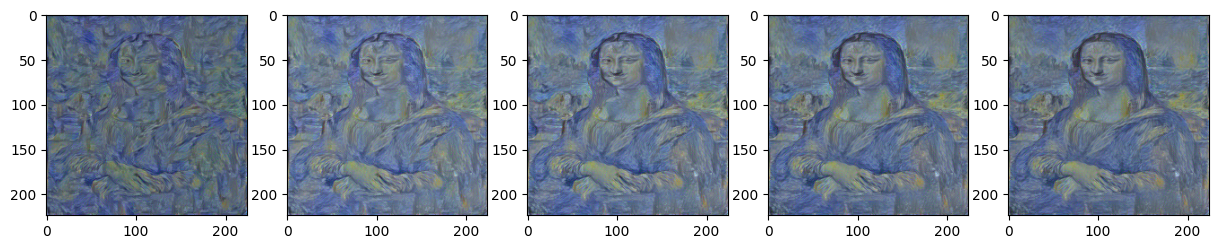

In [31]:
col = len(out)
fig, ax = plt.subplots(1, col, figsize=(3*col, 5))
for i in range(col):
    ax[i].imshow(out[i])

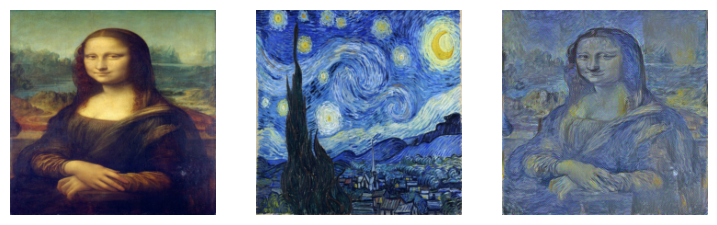

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(9, 5))
ax[0].imshow(to_output(content_image))
ax[1].imshow(to_output(style_image))
ax[2].imshow(out[-1])
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()